# Importation des bibliotheques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import re
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Importation des 5 jeux de donnees

In [3]:
serie = pd.read_csv("trafic_aerien/AirPassengers.csv", index_col=0, parse_dates=[0])
serie.rename(columns={'#Passengers': 'passagers'}, inplace=True)

champagne = pd.read_csv("monthly_champagne_sales.csv", index_col=0, parse_dates=[0])
champagne.rename(columns={'Sales': 'vente'}, inplace=True)

demo = pd.read_csv("demographie_usa/POP.csv", index_col=2, parse_dates=[2])
demo.drop(['realtime_start', 'realtime_end'], inplace=True, axis=1)
demo.rename(columns={"value": "population"}, inplace=True)

gasoline=pd.read_csv("Gasoline.csv", index_col=0, parse_dates=[0])

bourse = pd.read_csv("bourse_nationnale/infy_stock.csv", index_col=0, parse_dates=[0])
bourse.drop(['Symbol', 'Series', 'Prev Close', 'Last', 'Open', 'High', 'Low', 'VWAP', 'Volume', 'Turnover', '%Deliverble', 'Trades', 'Deliverable Volume'], inplace=True, axis=1)

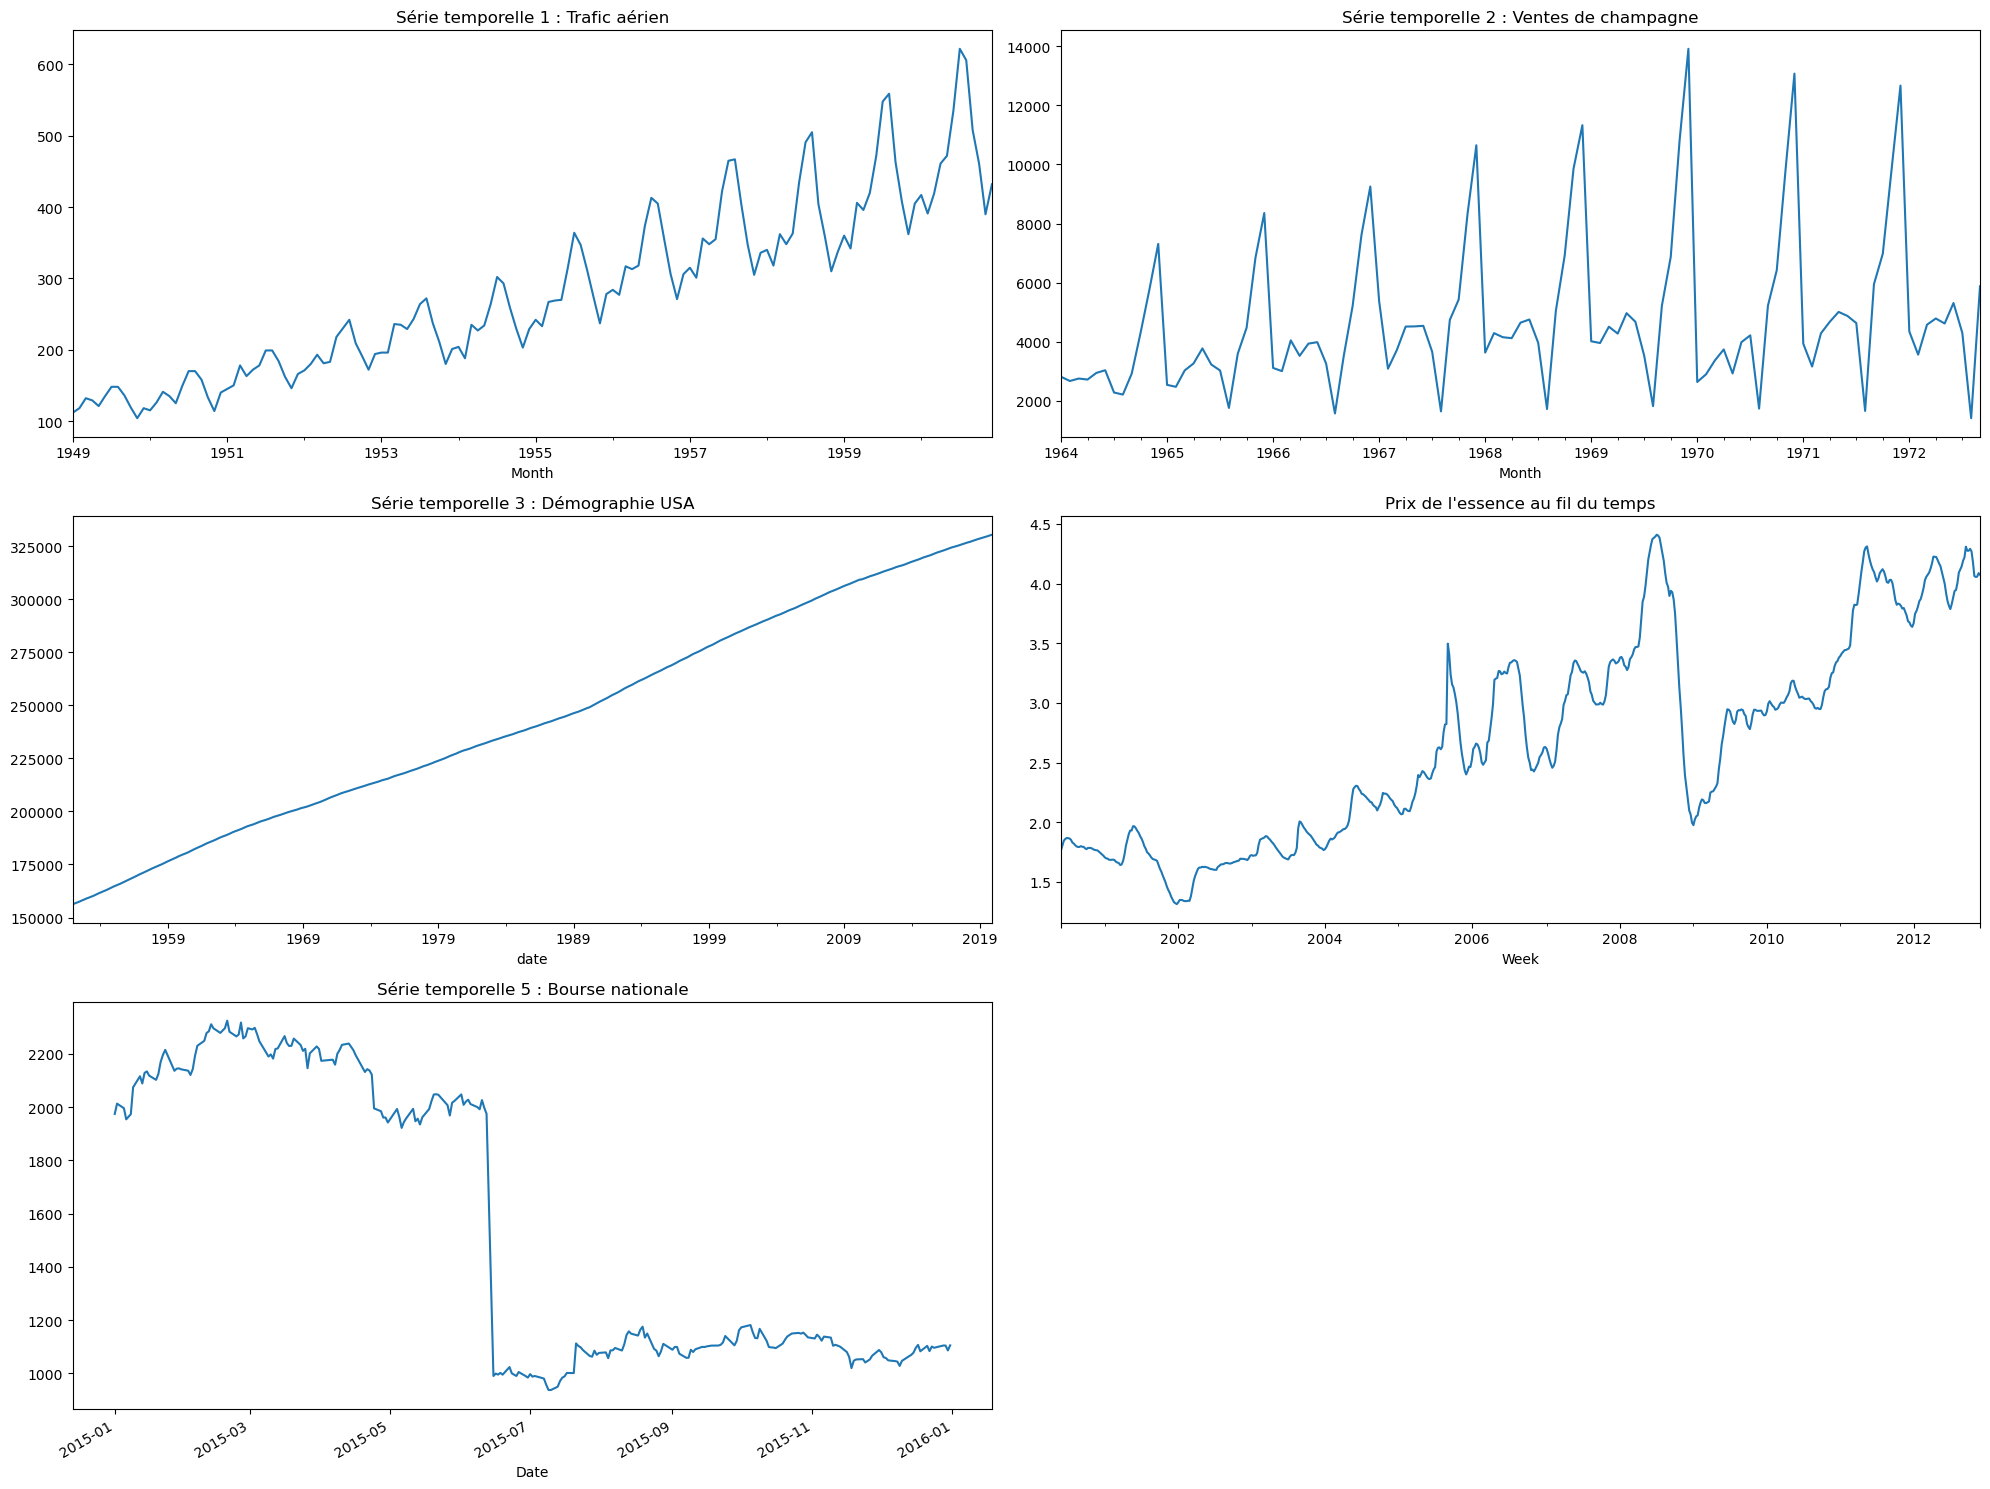

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))


serie['passagers'].plot(ax=axs[0, 0], title='Série temporelle 1 : Trafic aérien')
champagne['vente'].plot(ax=axs[0, 1], title='Série temporelle 2 : Ventes de champagne')
demo['population'].plot(ax=axs[1, 0], title='Série temporelle 3 : Démographie USA')
gasoline['Gas Price'].plot(ax=axs[1, 1], title='Prix de l\'essence au fil du temps')
bourse['Close'].plot(ax=axs[2, 0], title='Série temporelle 5 : Bourse nationale')

# Supprimer le dernier subplot qui est vide
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

# Application des differents lissages sur les jeux d'entrainement et calcul des erreurs

In [5]:
import dataframe_image as dfi

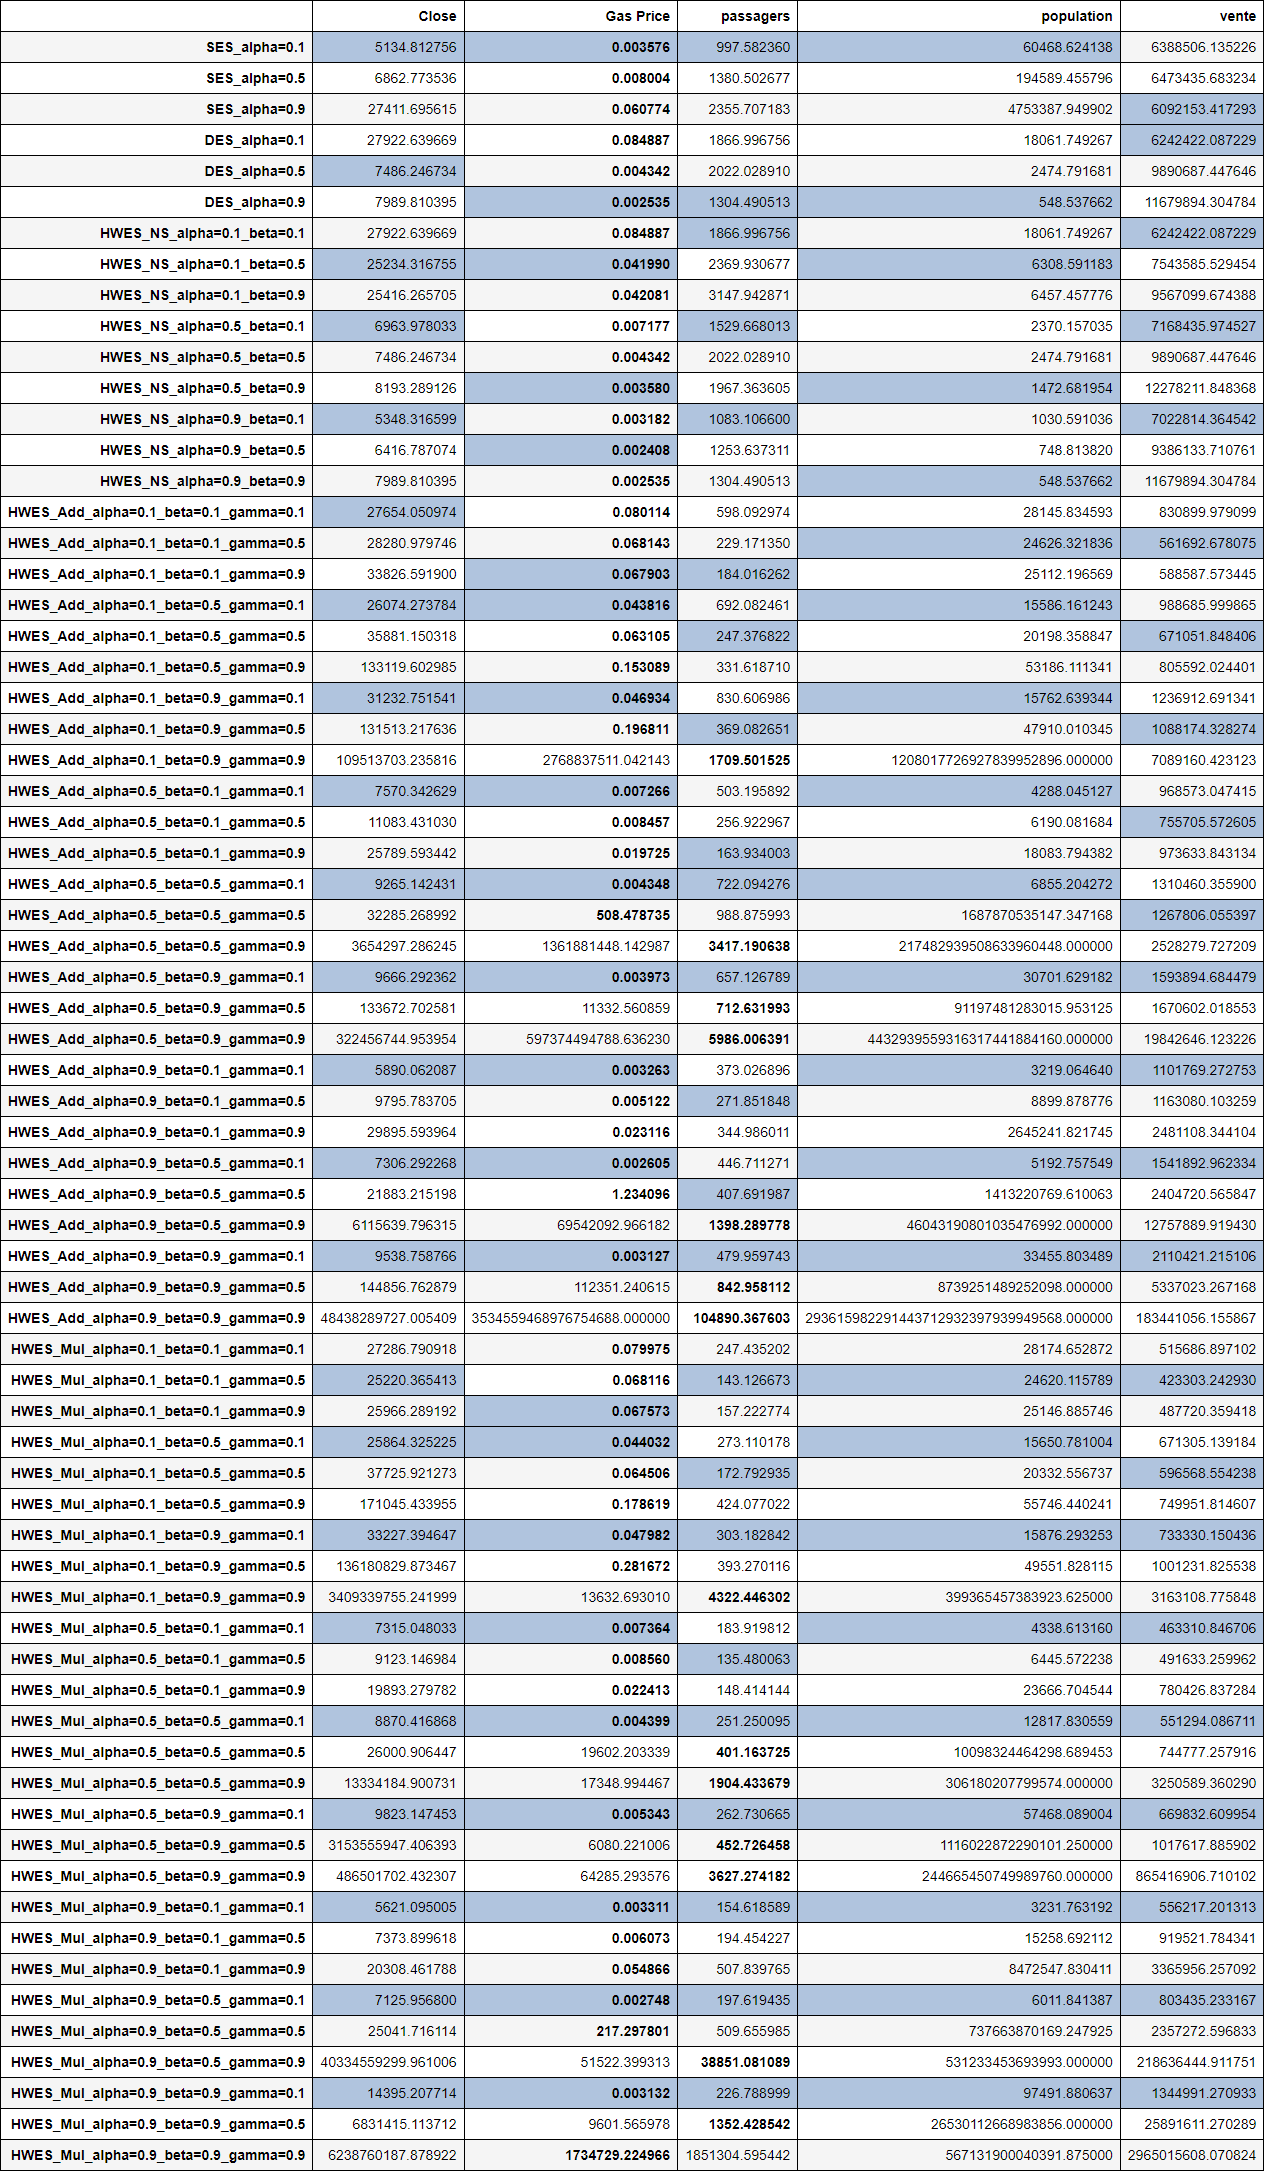

In [6]:

# Données simulées
data = {
    'passagers': serie,
    'vente': champagne,
    'population': demo,
    'Gas Price': gasoline,
    'Close': bourse
}
series_names = list(data.keys())

alphas = [0.1, 0.5, 0.9]
betas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]

# Fonction pour appliquer le lissage exponentiel simple et calculer le MSE sur l'ensemble d'entraînement
def apply_ses_and_calculate_mse(series, alpha):
    train_size = int(len(series) * 0.9)
    train = series.iloc[:train_size]
    model = SimpleExpSmoothing(train).fit(smoothing_level=1-alpha, optimized=False)
    predictions = model.fittedvalues
    mse = mean_squared_error(train, predictions)
    return mse

# Fonction pour appliquer le lissage exponentiel double et calculer le MSE sur l'ensemble d'entraînement
def apply_des_and_calculate_mse(series, alpha):
    train_size = int(len(series) * 0.9)
    train = series.iloc[:train_size]
    model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=alpha, smoothing_slope=alpha, optimized=False)
    predictions = model.fittedvalues
    mse = mean_squared_error(train, predictions)
    return mse

# Fonction pour appliquer le lissage exponentiel Holt-Winters non saisonnier et calculer le MSE
def apply_hwes_ns_and_calculate_mse(series, alpha, beta):
    train_size = int(len(series) * 0.9)
    train = series.iloc[:train_size]
    model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(
        smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    predictions = model.fittedvalues
    mse = mean_squared_error(train, predictions)
    return mse

# Fonction pour appliquer le lissage exponentiel Holt-Winters saisonnier additif et calculer le MSE
def apply_hwes_add_and_calculate_mse(series, alpha, beta, gamma):
    train_size = int(len(series) * 0.9)
    train = series.iloc[:train_size]
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(
        smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)
    predictions = model.fittedvalues
    mse = mean_squared_error(train, predictions)
    return mse

# Fonction pour appliquer le lissage exponentiel Holt-Winters saisonnier multiplicatif et calculer le MSE
def apply_hwes_mul_and_calculate_mse(series, alpha, beta, gamma):
    train_size = int(len(series) * 0.9)
    train = series.iloc[:train_size]
    model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(
        smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)
    predictions = model.fittedvalues
    mse = mean_squared_error(train, predictions)
    return mse

# Calculer le MSE pour chaque série et chaque combinaison de paramètres
mse_results = []

for alpha in alphas:
    for series_name in series_names:
        series = data[series_name]
        mse_ses = apply_ses_and_calculate_mse(series, alpha)
        mse_des = apply_des_and_calculate_mse(series, alpha)
        mse_results.append((f'SES_alpha={alpha}', series_name, mse_ses))
        mse_results.append((f'DES_alpha={alpha}', series_name, mse_des))
        
for alpha in alphas:
    for beta in betas:
        for series_name in series_names:
            series = data[series_name]
            mse_hwes_ns = apply_hwes_ns_and_calculate_mse(series, alpha, beta)
            mse_results.append((f'HWES_NS_alpha={alpha}_beta={beta}', series_name, mse_hwes_ns))

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            for series_name in series_names:
                series = data[series_name]
                mse_hwes_add = apply_hwes_add_and_calculate_mse(series, alpha, beta, gamma)
                mse_hwes_mul = apply_hwes_mul_and_calculate_mse(series, alpha, beta, gamma)
                mse_results.append((f'HWES_Add_alpha={alpha}_beta={beta}_gamma={gamma}', series_name, mse_hwes_add))
                mse_results.append((f'HWES_Mul_alpha={alpha}_beta={beta}_gamma={gamma}', series_name, mse_hwes_mul))

# Convertir les résultats en DataFrame pour une meilleure lisibilité
mse_df = pd.DataFrame(mse_results, columns=['Method', 'Serie', 'MSE'])

# Pivot le DataFrame pour avoir le format désiré
pivot_df = mse_df.pivot(index='Method', columns='Serie', values='MSE')

# Réorganiser l'ordre des méthodes de lissage dans les lignes
method_order = [f'SES_alpha={alpha}' for alpha in alphas] + \
               [f'DES_alpha={alpha}' for alpha in alphas] + \
               [f'HWES_NS_alpha={alpha}_beta={beta}' for alpha in alphas for beta in betas] + \
               [f'HWES_Add_alpha={alpha}_beta={beta}_gamma={gamma}' for alpha in alphas for beta in betas for gamma in gammas] + \
               [f'HWES_Mul_alpha={alpha}_beta={beta}_gamma={gamma}' for alpha in alphas for beta in betas for gamma in gammas]

pivot_df = pivot_df.reindex(method_order)

# Ajouter une première cellule vide
pivot_df.index.name = None
pivot_df.columns.name = None

# Fonction pour mettre en évidence la valeur minimale dans chaque ligne et groupe de colonnes
def highlight_min_and_alpha(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    
    for row in df.index:
        min_row_col = df.loc[row, :].idxmin()
        styles.loc[row, min_row_col] += 'font-weight: bold;'
    
    num_alphas = len(alphas)
    for col in df.columns:
        for i in range(0, len(df.index), num_alphas):
            group = df.iloc[i:i+num_alphas, df.columns.get_loc(col)]
            min_group_row = group.idxmin()
            styles.loc[min_group_row, col] += 'background-color: LightSteelBlue;'
    
    return styles

# Appliquer la mise en évidence au DataFrame combiné
styled_pivot_df = pivot_df.style.apply(highlight_min_and_alpha, axis=None).set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
])

dfi.export(styled_pivot_df, 'styled_table.png')
#styled_pivot_df

# Afficher l'image générée
Image(filename='styled_table.png')


# Tracage des courbes

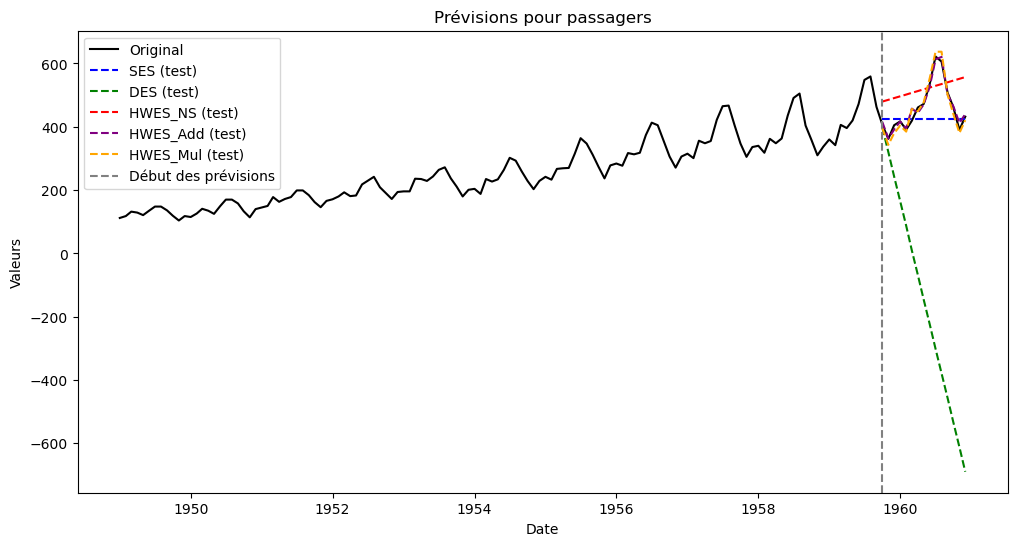

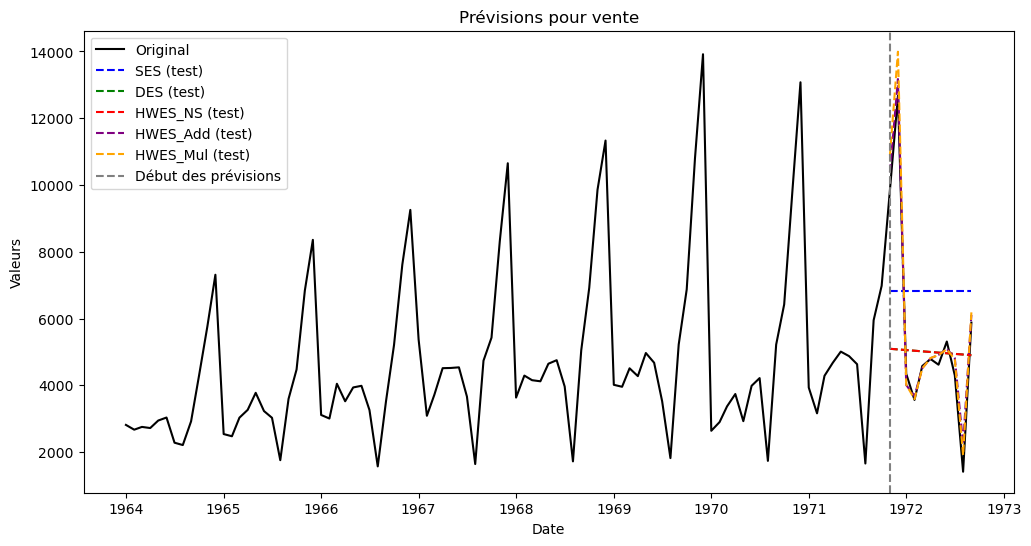

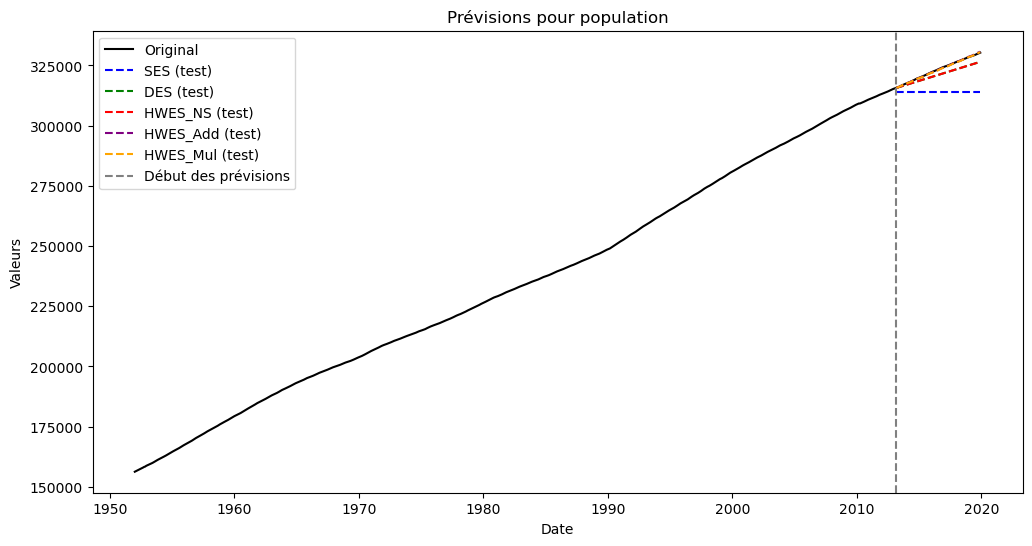

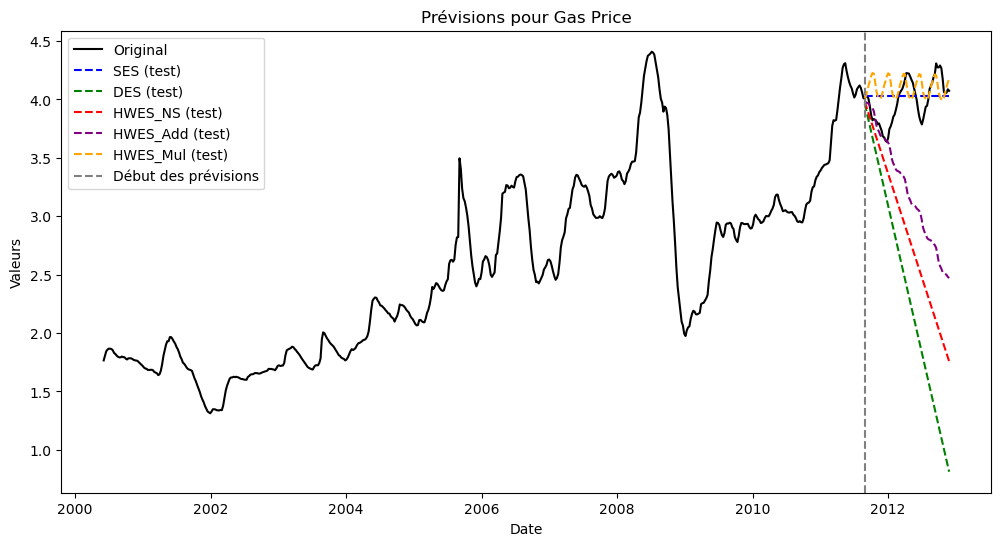

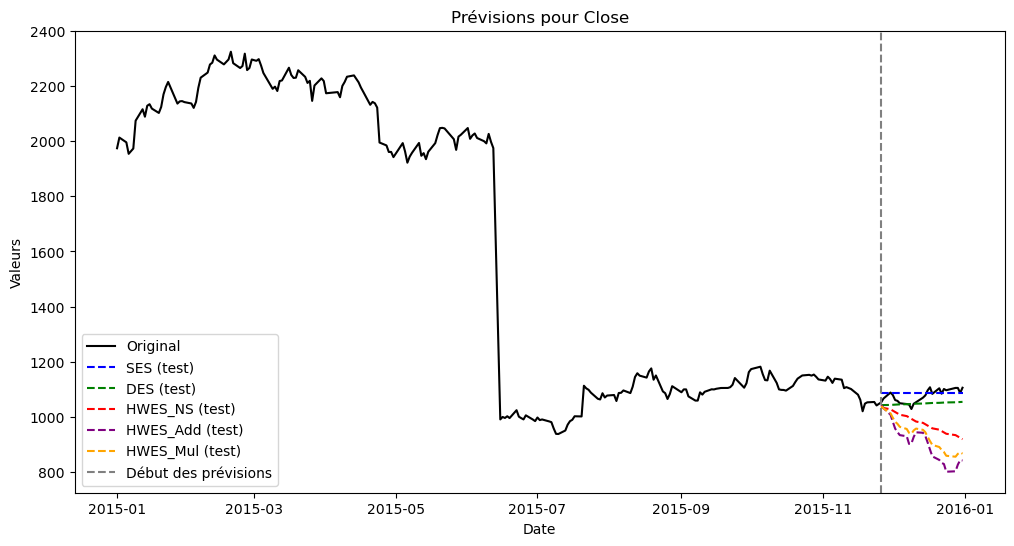

In [7]:
# Vos données simulées
data = {
    'passagers': serie,
    'vente': champagne,
    'population': demo,
    'Gas Price': gasoline,
    'Close': bourse
}
series_names = list(data.keys())

alphas = [0.1, 0.5, 0.9]
betas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]

# Fonction pour appliquer les modèles et calculer les prévisions sur les données de test
def apply_ses(series, alpha):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_des(series, alpha):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=alpha, smoothing_slope=alpha, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_hwes_ns(series, alpha, beta):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(
        smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_hwes_add(series, alpha, beta, gamma):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(
        smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_hwes_mul(series, alpha, beta, gamma):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(
        smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

# Calculer les meilleurs modèles
mse_results = []

for alpha in alphas:
    for series_name in series_names:
        series = data[series_name]
        mse_ses = apply_ses_and_calculate_mse(series, alpha)
        mse_des = apply_des_and_calculate_mse(series, alpha)
        mse_results.append((f'SES_alpha={alpha}', series_name, mse_ses))
        mse_results.append((f'DES_alpha={alpha}', series_name, mse_des))
        
for alpha in alphas:
    for beta in betas:
        for series_name in series_names:
            series = data[series_name]
            mse_hwes_ns = apply_hwes_ns_and_calculate_mse(series, alpha, beta)
            mse_results.append((f'HWES_NS_alpha={alpha}_beta={beta}', series_name, mse_hwes_ns))

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            for series_name in series_names:
                series = data[series_name]
                mse_hwes_add = apply_hwes_add_and_calculate_mse(series, alpha, beta, gamma)
                mse_hwes_mul = apply_hwes_mul_and_calculate_mse(series, alpha, beta, gamma)
                mse_results.append((f'HWES_Add_alpha={alpha}_beta={beta}_gamma={gamma}', series_name, mse_hwes_add))
                mse_results.append((f'HWES_Mul_alpha={alpha}_beta={beta}_gamma={gamma}', series_name, mse_hwes_mul))

# Convertir les résultats en DataFrame pour une meilleure lisibilité
mse_df = pd.DataFrame(mse_results, columns=['Method', 'Serie', 'MSE'])

# Pivot le DataFrame pour avoir le format désiré
pivot_df = mse_df.pivot(index='Method', columns='Serie', values='MSE')

# Récupérer les meilleurs modèles pour chaque série
best_models = pivot_df.idxmin()

# Fonction pour extraire les paramètres avec une expression régulière
def extract_params(best_model, pattern):
    match = re.match(pattern, best_model)
    if match:
        return [float(x) for x in match.groups()]
    else:
        raise ValueError(f"Le modèle '{best_model}' ne correspond pas au motif attendu.")

# Tracer les courbes de prévision pour chaque série
for series_name in series_names:
    series = data[series_name]
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original', color='black')

    # SES
    best_ses_model = pivot_df.loc[[method for method in pivot_df.index if method.startswith('SES')], series_name].idxmin()
    ses_alpha = extract_params(best_ses_model, r'SES_alpha=(\d\.\d)')[0]
    train, test, ses_predictions = apply_ses(series, ses_alpha)
    plt.plot(test.index, ses_predictions, label='SES (test)', linestyle='dashed', color='blue')

    # DES
    best_des_model = pivot_df.loc[[method for method in pivot_df.index if method.startswith('DES')], series_name].idxmin()
    des_alpha = extract_params(best_des_model, r'DES_alpha=(\d\.\d)')[0]
    train, test, des_predictions = apply_des(series, des_alpha)
    plt.plot(test.index, des_predictions, label='DES (test)', linestyle='dashed', color='green')

    # HWES_NS
    best_hwes_ns_model = pivot_df.loc[[method for method in pivot_df.index if method.startswith('HWES_NS')], series_name].idxmin()
    hwes_ns_alpha, hwes_ns_beta = extract_params(best_hwes_ns_model, r'HWES_NS_alpha=(\d\.\d)_beta=(\d\.\d)')
    train, test, hwes_ns_predictions = apply_hwes_ns(series, hwes_ns_alpha, hwes_ns_beta)
    plt.plot(test.index, hwes_ns_predictions, label='HWES_NS (test)', linestyle='dashed', color='red')

    # HWES_Add
    best_hwes_add_model = pivot_df.loc[[method for method in pivot_df.index if method.startswith('HWES_Add')], series_name].idxmin()
    hwes_add_alpha, hwes_add_beta, hwes_add_gamma = extract_params(best_hwes_add_model, r'HWES_Add_alpha=(\d\.\d)_beta=(\d\.\d)_gamma=(\d\.\d)')
    train, test, hwes_add_predictions = apply_hwes_add(series, hwes_add_alpha, hwes_add_beta, hwes_add_gamma)
    plt.plot(test.index, hwes_add_predictions, label='HWES_Add (test)', linestyle='dashed', color='purple')

    # HWES_Mul
    best_hwes_mul_model = pivot_df.loc[[method for method in pivot_df.index if method.startswith('HWES_Mul')], series_name].idxmin()
    hwes_mul_alpha, hwes_mul_beta, hwes_mul_gamma = extract_params(best_hwes_mul_model, r'HWES_Mul_alpha=(\d\.\d)_beta=(\d\.\d)_gamma=(\d\.\d)')
    train, test, hwes_mul_predictions = apply_hwes_mul(series, hwes_mul_alpha, hwes_mul_beta, hwes_mul_gamma)
    plt.plot(test.index, hwes_mul_predictions, label='HWES_Mul (test)', linestyle='dashed', color='orange')

    # Tracer une ligne verticale pour indiquer le début des prévisions
    plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Début des prévisions')

    plt.title(f'Prévisions pour {series_name}')
    plt.xlabel('Date')
    plt.ylabel('Valeurs')
    plt.legend()
    plt.show()

# Calculer les erreurs sur le jeu de test et afficher le tableau des erreurs

In [8]:
# Vos données simulées
data = {
    'passagers': serie,
    'vente': champagne,
    'population': demo,
    'Gas Price': gasoline,
    'Close': bourse
}
series_names = list(data.keys())

alphas = [0.1, 0.5, 0.9]
betas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]

# Fonctions pour appliquer les modèles et calculer les prévisions sur les données de test
def apply_ses(series, alpha):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = SimpleExpSmoothing(train).fit(smoothing_level=1-alpha, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_des(series, alpha):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=alpha, smoothing_slope=alpha, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_hwes_ns(series, alpha, beta):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_hwes_add(series, alpha, beta, gamma):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

def apply_hwes_mul(series, alpha, beta, gamma):
    train_size = int(len(series) * 0.9)
    train, test = series.iloc[:train_size], series.iloc[train_size:]
    model = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)
    predictions = model.forecast(len(test))
    return train, test, predictions

# Calculer les erreurs pour chaque série et chaque type de lissage
errors = []

for series_name in series_names:
    series = data[series_name]
    
    # Simple Exponential Smoothing
    for alpha in alphas:
        train, test, predictions = apply_ses(series, alpha)
        mse = mean_squared_error(test, predictions)
        errors.append(('Lissage Exponentiel Simple', series_name, mse))
    
    # Double Exponential Smoothing
    for alpha in alphas:
        train, test, predictions = apply_des(series, alpha)
        mse = mean_squared_error(test, predictions)
        errors.append(('Lissage Exponentiel Double', series_name, mse))
    
    # Holt-Winters Non-Saisonnier
    for alpha in alphas:
        for beta in betas:
            train, test, predictions = apply_hwes_ns(series, alpha, beta)
            mse = mean_squared_error(test, predictions)
            errors.append(('Holt-Winters Non-Saisonnier', series_name, mse))
    
    # Holt-Winters Additif
    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                train, test, predictions = apply_hwes_add(series, alpha, beta, gamma)
                mse = mean_squared_error(test, predictions)
                errors.append(('Holt-Winters Additif', series_name, mse))
    
    # Holt-Winters Multiplicatif
    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                train, test, predictions = apply_hwes_mul(series, alpha, beta, gamma)
                mse = mean_squared_error(test, predictions)
                errors.append(('Holt-Winters Multiplicatif', series_name, mse))

# Convertir les résultats en DataFrame pour une meilleure lisibilité
errors_df = pd.DataFrame(errors, columns=['Method', 'Series', 'MSE'])

# Supprimer les doublons dans l'index avant de pivoter
errors_df = errors_df.drop_duplicates(subset=['Method', 'Series'])

# Définir l'ordre des méthodes
methods_order = [
    'Lissage Exponentiel Simple',
    'Lissage Exponentiel Double',
    'Holt-Winters Non-Saisonnier',
    'Holt-Winters Additif',
    'Holt-Winters Multiplicatif'
]

# Pivot le DataFrame pour avoir le format désiré
errors_pivot_df = errors_df.pivot(index='Method', columns='Series', values='MSE')

dfi.export(errors_pivot_df, 'errors_pivot_df.png')
#styled_pivot_df

# Afficher l'image générée
Image(filename='errors_pivot_df.png')
# Réordonner les méthodes
errors_pivot_df = errors_pivot_df.loc[methods_order]

styled_errors_pivot_df = errors_pivot_df.style.set_table_styles([
    {'selector': 'th', 'props': [('border', '2px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]}
])

dfi.export(styled_errors_pivot_df, 'styled_table_erreur.png')
styled_errors_pivot_df


Series,Close,Gas Price,passagers,population,vente
Method,,,,,
Lissage Exponentiel Simple,1647.142033,0.034095,5843.692823,77664075.758941,10308110.067009
Lissage Exponentiel Double,5180.734113,0.860764,5245.012494,57870.194027,8831847.804373
Holt-Winters Non-Saisonnier,5180.734113,0.860764,5245.012494,57870.194027,8831847.804373
Holt-Winters Additif,5207.034281,0.730938,1428.631846,59615.346054,623100.141475
Holt-Winters Multiplicatif,5436.581551,0.739032,922.693911,62356.729179,239407.102399
